In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [37]:
data_train = pd.read_csv('bancoML.csv')

In [38]:
data_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
10041,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
10042,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
10043,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [39]:
data_train['deposit'].value_counts()

deposit
no     5271
yes    4774
Name: count, dtype: int64

#### 1. Marcar 'duration' como variable no predictiva (solo para análisis posterior)

In [40]:
print(data_train[['duration', 'deposit']].groupby('deposit').mean())

           duration
deposit            
no       223.097894
yes      538.203603


In [41]:
df_clean = data_train.drop(columns=['duration'])

#### 2. Estandarizar valores categóricos binarios: 'yes'/'no' a 1/0

In [42]:
binary_cols = ['default', 'housing', 'loan', 'deposit']
for col in binary_cols:
    df_clean[col] = df_clean[col].map({'yes': 1, 'no': 0})

In [43]:
for col in ['default', 'housing', 'loan', 'deposit']:
    print(data_train[col].value_counts())

default
no     9898
yes     147
Name: count, dtype: int64
housing
no     5296
yes    4749
Name: count, dtype: int64
loan
no     8759
yes    1286
Name: count, dtype: int64
deposit
no     5271
yes    4774
Name: count, dtype: int64


In [44]:
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1,-1,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1,-1,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1,-1,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,may,1,-1,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,may,2,-1,0,unknown,1


#### 3. Codificar variables categóricas múltiples con LabelEncoder (para clustering)

In [45]:
for col in ['job', 'marital', 'education', 'contact', 'month', 'poutcome']:
    print(data_train[col].value_counts())
    print(data_train[col].nunique())

job
management       2323
blue-collar      1748
technician       1620
admin.           1209
services          835
retired           709
self-employed     359
student           328
unemployed        319
entrepreneur      291
housemaid         242
unknown            62
Name: count, dtype: int64
12
marital
married     5723
single      3168
divorced    1154
Name: count, dtype: int64
3
education
secondary    4926
tertiary     3313
primary      1352
unknown       454
Name: count, dtype: int64
4
contact
cellular     7236
unknown      2106
telephone     703
Name: count, dtype: int64
3
month
may    2525
jul    1369
aug    1359
jun    1105
nov     857
apr     833
feb     698
oct     349
jan     306
sep     295
mar     252
dec      97
Name: count, dtype: int64
12
poutcome
unknown    7470
failure    1116
success     968
other       491
Name: count, dtype: int64
4


In [46]:
label_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le

In [47]:
print(df_clean[col].head(5))

0    3
1    3
2    3
3    3
4    3
Name: poutcome, dtype: int32


In [48]:
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,2,-1,0,3,1


####  Marcar valores extremos (sin eliminarlos aún)

In [49]:
df_clean['balance_negative'] = (df_clean['balance'] < 0).astype(int)
df_clean['age_extreme'] = (df_clean['age'] > 85).astype(int)
df_clean['campaign_extreme'] = (df_clean['campaign'] > 20).astype(int)
df_clean['pdays_extreme'] = (df_clean['pdays'] > 500).astype(int)

In [50]:
outliers_df = df_clean[
    (df_clean['balance_negative'] == 1) |
    (df_clean['age_extreme'] == 1) |
    (df_clean['campaign_extreme'] == 1) |
    (df_clean['pdays_extreme'] == 1)
]

In [51]:
outliers_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,balance_negative,age_extreme,campaign_extreme,pdays_extreme
16,49,7,1,1,0,-8,1,0,2,8,8,1,-1,0,3,1,1,0,0,0
26,32,1,1,1,1,-1,1,0,2,9,8,1,-1,0,3,1,1,0,0,0
37,45,2,0,2,0,-395,1,0,2,13,8,1,-1,0,3,1,1,0,0,0
54,57,9,1,2,0,-1,0,0,2,14,8,2,-1,0,3,1,1,0,0,0
56,52,1,0,0,0,-191,1,0,2,15,8,1,-1,0,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10005,39,4,1,2,0,-974,0,1,0,13,1,4,-1,0,3,0,1,0,0,0
10006,50,4,1,2,0,-516,1,0,2,15,8,2,-1,0,3,0,1,0,0,0
10017,32,1,1,1,0,-325,1,1,2,21,8,1,-1,0,3,0,1,0,0,0
10029,60,5,0,2,0,-134,0,0,0,12,8,1,271,4,0,0,1,0,0,0


In [52]:
df_cluster = df_clean[
    (df_clean['balance_negative'] == 0) &
    (df_clean['age_extreme'] == 0) &
    (df_clean['campaign_extreme'] == 0) &
    (df_clean['pdays_extreme'] == 0)
].copy()

df_cluster.drop(columns=['balance_negative', 'age_extreme', 'campaign_extreme', 'pdays_extreme'], inplace=True)

In [53]:
df_cluster

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,2,-1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,33,1,2,0,0,1,1,0,0,20,0,1,-1,0,3,0
10041,39,7,1,1,0,733,0,0,2,16,6,4,-1,0,3,0
10042,32,9,2,1,0,29,0,0,0,19,1,2,-1,0,3,0
10043,43,9,1,1,0,0,0,1,0,8,8,2,172,5,0,0


In [54]:
df_cluster['pdays'].value_counts()

pdays
-1      6884
 92       89
 182      83
 181      75
 91       71
        ... 
 424       1
 450       1
 224       1
 376       1
 118       1
Name: count, Length: 413, dtype: int64

In [55]:
df_cluster.to_csv("bancoML_sin_outliers.csv", index=False)

#### Segmentación de clientes aplicando aprendizaje no supervizado:

In [56]:
df_segmentacion = pd.read_csv("bancoML_sin_outliers.csv")

In [57]:
features = [
    'age', 'balance', 'campaign',
    'job', 'marital', 'education', 'contact', 
    'poutcome', 'housing', 'loan'
]

X = df_segmentacion[features]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans con N clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto', max_iter=300, )
clusters = kmeans.fit_predict(X_scaled)
df_segmentacion['cluster'] = clusters

# Reducción a 2D para visualizar clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_segmentacion['pca1'] = X_pca[:, 0]
df_segmentacion['pca2'] = X_pca[:, 1]

In [58]:
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.139


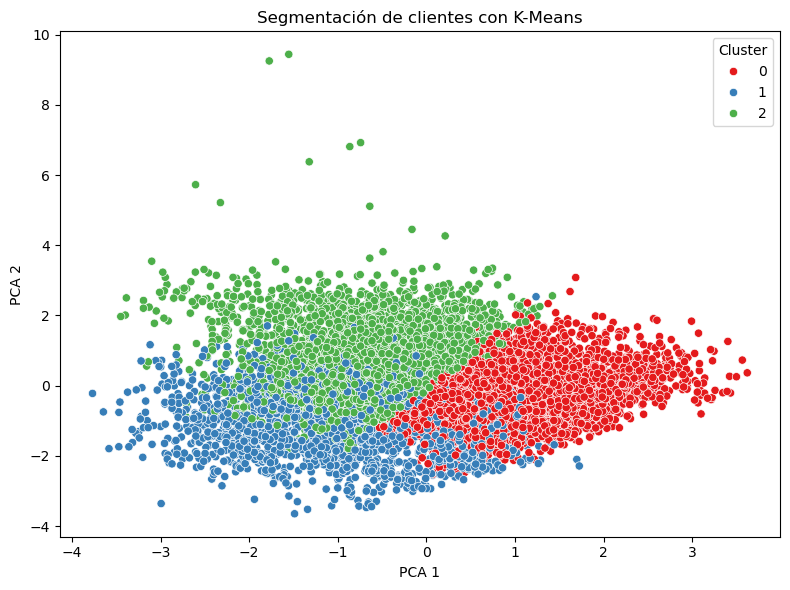

In [59]:
# Visualización
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_segmentacion, x='pca1', y='pca2', hue='cluster', palette='Set1')
plt.title("Segmentación de clientes con K-Means")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [60]:
df_segmentacion.groupby('cluster')[features].mean()

,age,balance,campaign,job,marital,education,contact,poutcome,housing,loan
cluster,,,,,,,,,,
0,32.947922,1446.339821,2.248553,5.248553,1.628090,1.559705,0.040768,2.234350,0.420305,0.089690
1,40.824024,1377.026693,2.668314,3.868018,1.141869,1.104301,1.925358,2.981710,0.719229,0.127039
2,50.673783,2043.718759,2.416453,4.103615,0.793908,1.128096,0.105323,2.420154,0.342727,0.136351


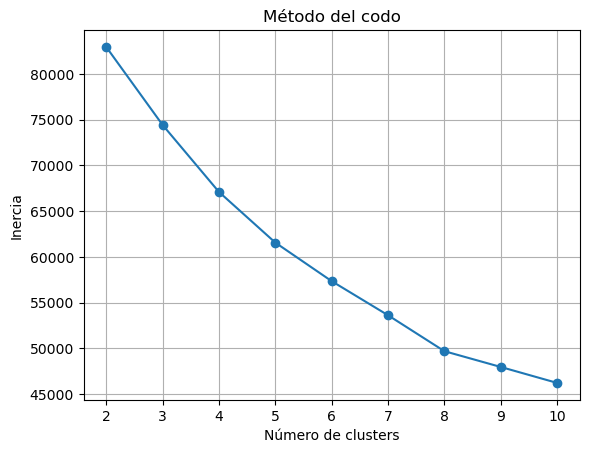

In [61]:
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.grid(True)
plt.show()

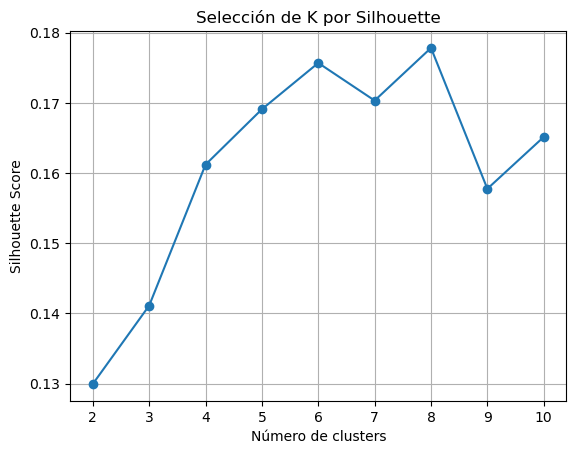

In [62]:
sil_scores = []
ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.title("Selección de K por Silhouette")
plt.grid(True)
plt.show()

#### Probando otros metodos de segmentacion mediante aprendizaje no supervisado:

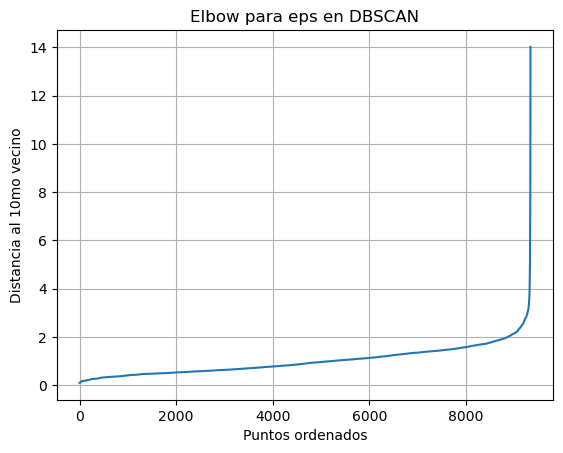

In [63]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = sorted(distances[:, 9])
plt.plot(distances)
plt.title("Elbow para eps en DBSCAN")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 10mo vecino")
plt.grid(True)
plt.show()

In [64]:
df_dbscan = df_segmentacion.drop('cluster', axis=1).copy()

dbscan = DBSCAN(eps=3.0, min_samples=10)
labels_db = dbscan.fit_predict(X_scaled)

# Agregar etiquetas al DataFrame
df_dbscan['dbscan_cluster'] = labels_db

# Evaluar solo si hay más de 1 cluster válido
if len(set(labels_db)) > 1:
    score_db = silhouette_score(X_scaled, labels_db)
    print(f"Silhouette Score (DBSCAN): {score_db:.3f}")
else:
    print("DBSCAN detectó un solo grupo o solo ruido.")

Silhouette Score (DBSCAN): 0.217


In [65]:
unique, counts = np.unique(df_dbscan['dbscan_cluster'], return_counts=True)
print(dict(zip(unique, counts)))

{-1: 23, 0: 8245, 1: 1070}


In [66]:
df_dbscan.groupby('dbscan_cluster')[['age', 'balance', 'campaign', 'pdays']].mean()

,age,balance,campaign,pdays
dbscan_cluster,,,,
-1,50.217391,35596.695652,6.521739,44.739130
0,41.402668,1655.306731,2.379381,51.059430
1,40.515888,932.303738,2.493458,43.266355


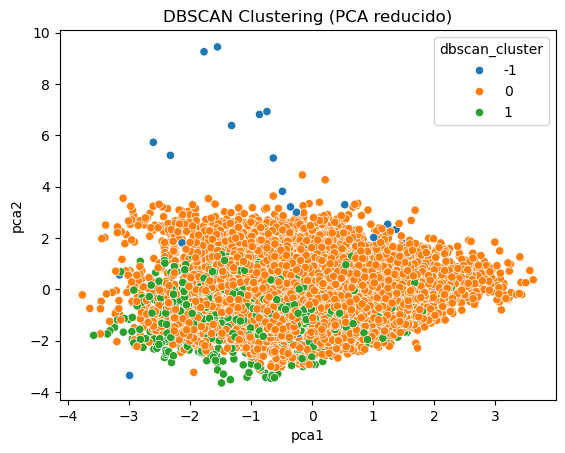

In [67]:
sns.scatterplot(x=df_dbscan['pca1'], y=df_dbscan['pca2'], hue=df_dbscan['dbscan_cluster'], palette='tab10')
plt.title("DBSCAN Clustering (PCA reducido)")
plt.show()

In [68]:
df_ac = df_segmentacion.drop('cluster', axis=1).copy()
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)
df_ac['agg_cluster'] = labels_agg

# Silhouette Score
score_agg = silhouette_score(X_scaled, labels_agg)
print(f"Silhouette Score (Agglomerative): {score_agg:.3f}")

Silhouette Score (Agglomerative): 0.135


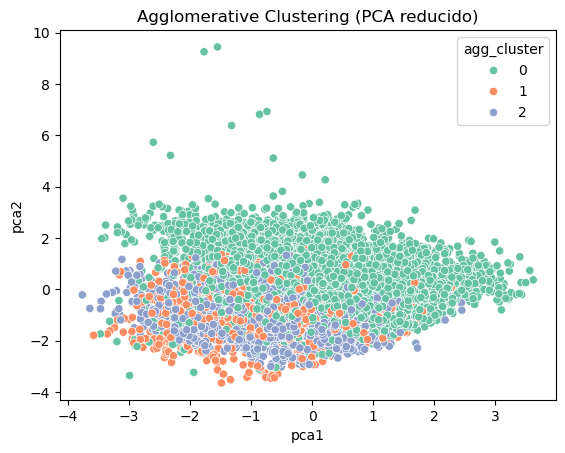

In [69]:
sns.scatterplot(x=df_ac['pca1'], y=df_ac['pca2'], hue=df_ac['agg_cluster'], palette='Set2')
plt.title("Agglomerative Clustering (PCA reducido)")
plt.show()